### Calibration plots

This notebook will create plots reggarding the calibration process


A brief summary of the organization of this notebook:

### Summary

- [1 - Packages and imports](#1)

- [2 - Reading experimental data](#2)

- [3 - Plotting the PSD and calibrating the force](#3)

<a name='1'></a> 
### 1. Packages and imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit
import non_linearity.utils.constants as ct
from scipy import signal as sn
from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy

In [2]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})

<a name='2'></a> 
### 2. Reading experimental data

In [3]:
psd = pd.read_pickle("../data/calibration/PSDtrimmed.pkl")


<a name='3'></a> 
### 3. Plotting the PSD and calibrating the force

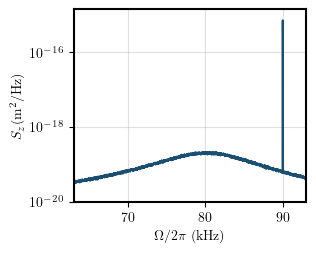

In [10]:
power = unumpy.nominal_values(psd['power [m**2/Hz]'].values)
ax = plt.gca()
ax.grid(alpha = 0.4)
ax.figure.set_size_inches(3, 2.5, forward=True)
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
ax.plot(psd['f [Hz]'].values/1e3, power, color=colors[2])
ax.set_xlim([63, 93])
ax.set_ylim([10**-20, 2*max(power)])
ax.set_yscale('log')
ax.set(ylabel=r'$S_z(\textrm{m}{}^2$/Hz)')
ax.set(xlabel=r'$\Omega/2\pi$ (kHz)')
#ax.legend(fontsize=8)
plt.savefig('../plots/psd_trimmed_calibration.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [5]:
calib_data = pd.read_pickle("../data/calibration/voltageVSforce.pkl")
calib_data

,voltage [V],electric force [N]
0,1.0,(2.87+/-0.25)e-15
1,2.0,(5.5+/-0.5)e-15
2,3.0,(8.7+/-0.8)e-15
3,4.0,(1.23+/-0.11)e-14
4,5.0,(1.55+/-0.14)e-14
5,6.0,(1.78+/-0.16)e-14
6,7.0,(2.15+/-0.19)e-14
7,8.0,(2.45+/-0.21)e-14
8,9.0,(2.74+/-0.24)e-14
9,10.0,(3.02+/-0.26)e-14


In [6]:
def linearRegression(x,a,b):
    
    return a*x+b

In [7]:
hint_a = (unumpy.nominal_values(calib_data['electric force [N]'][len(calib_data)-1]) 
          - unumpy.nominal_values(calib_data['electric force [N]'][0]))/(unumpy.nominal_values(calib_data['voltage [V]'][len(calib_data)-1]) - unumpy.nominal_values(calib_data['voltage [V]'][0]))
hint_b = unumpy.nominal_values(calib_data['electric force [N]'][len(calib_data)-1]) - hint_a*unumpy.nominal_values(calib_data['voltage [V]'][len(calib_data)-1])

ans, cov = curve_fit(linearRegression, calib_data['voltage [V]'], 
                unumpy.nominal_values(calib_data['electric force [N]']),
                p0 = [hint_a,hint_b],
                sigma= unumpy.std_devs(calib_data['electric force [N]']), 
                absolute_sigma=True)


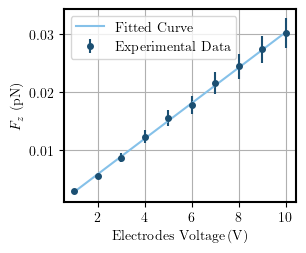

In [9]:
ax = plt.gca()
ax.figure.set_size_inches(3, 2.5, forward=True)
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
ax.errorbar(calib_data['voltage [V]'].values, 
            unumpy.nominal_values(calib_data['electric force [N]'].values)*1e12, 
            yerr=unumpy.std_devs(calib_data['electric force [N]'].values)*1e12,
              xerr=None , fmt='o', markersize=4, color=colors[2])
ax.plot(calib_data['voltage [V]'].values,
        linearRegression(calib_data['voltage [V]'].values, ans[0], ans[1])*1e12, 
        color=colors[1])
plt.grid()
plt.xlabel(r'$\textrm{Electrodes Voltage} \,(\textrm{V})$')
plt.ylabel(r'$F_z $ (pN)')
plt.legend(['Fitted Curve', 'Experimental Data'])
plt.savefig('../plots/electrode_calibration.pdf', bbox_inches='tight', dpi=300)
plt.show()